# Revising x-CAM Methods

### Introduction

This notebook revises x-CAM methods by introducing Label-free Activation Map (LaFAM), a streamlined approach utilizing raw activation maps for feature attribution without reliance on labels. LaFAM offers an efficient alternative to former CAM methods, maintaining efficacy in saliency map generation and model debugging across various learning paradigms.

### Prerequisites

```bash
pip install quantus
pip install captum
pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade
```

In [ ]:
import random
import json
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F

import pandas as pd

from captum.attr import LayerGradCam

import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

# fix seed for reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # multi-GPU

### Helper functions

In [2]:
def get_layer_idx(model, target_layer):
    for i, layer in enumerate(model.children()):
        if layer is target_layer:
            return i
    raise ValueError("Target layer not found in the model")


def normalize(masks):
    """
    Min-max normalization for each channel
    Args:
        masks (torch.Tensor): Masks BxCxWxH.

    """
    mins = masks.amin(dim=(-2, -1))
    maxs = masks.amax(dim=(-2, -1))
    # expand dims to [N activations, 1, 1]
    maxs, mins = maxs[:, None, None], mins[:, None, None]

    return (masks - mins) / (maxs - mins + 1e-8)


class SquareCropAndResize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        # Calculate the center crop size
        w, h = img.size
        new_size = min(w, h)

        # Center crop the image to a square
        left = (w - new_size) // 2
        top = (h - new_size) // 2
        right = (w + new_size) // 2
        bottom = (h + new_size) // 2
        img = img.crop((left, top, right, bottom))

        # Resize the image to the specified size
        img = img.resize((self.size, self.size), self.interpolation)

        return img


transform = torchvision.transforms.Compose(
    [
        SquareCropAndResize(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

inverse_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Normalize(
            mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        ),
        torchvision.transforms.Normalize(
            mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]
        ),
    ]
)

## ResNet classifier

Load pretrained ResNet and extract all CNN layers

In [3]:
resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval().to(device)

layer_idx = get_layer_idx(resnet, resnet.layer4)
print("Layer index: ", layer_idx)

# Take only CCN layers
resnet_layer4 = torch.nn.Sequential(*list(resnet.children())[: layer_idx + 1])
resnet_layer4.eval()
list(resnet_layer4.children())[-1]

Layer index:  7


Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

## Self-supervised models

Load pretrained SimCLR and SWaV models with ResNet backbone and use outputs of the last CNN layer as raw activation maps.

In [ ]:
from pl_bolts.models.self_supervised import SimCLR, SwAV


simclr = (
    SimCLR.load_from_checkpoint(
        "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt",
        strict=False,
    )
    .encoder.eval()
    .to(device)
)
layer_idx = get_layer_idx(simclr, simclr.layer4)
simclr_layer4 = torch.nn.Sequential(*list(simclr.children())[: layer_idx + 1])
simclr_layer4.eval().to(device)

swav = (
    SwAV.load_from_checkpoint(
        "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt",
        strict=False,
    )
    .model.eval()
    .to(device)
)
layer_idx = get_layer_idx(swav, swav.layer4)
swav_layer4 = torch.nn.Sequential(*list(swav.children())[: layer_idx + 1])
swav_layer4.eval().to(device)

In [5]:
# Load labels from json file
with open("imagenet_class_index.json") as f:
    imagenet_labels = list(json.load(f).values())

# Simple demo

### Classify test image with the pretrained ResNet

243 bull mastiff
282 tiger cat
242 boxer
245 French bulldog
281 tabby, tabby cat
811 space heater
254 pug, pug-dog
539 doormat, welcome mat
180 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier
285 Egyptian cat


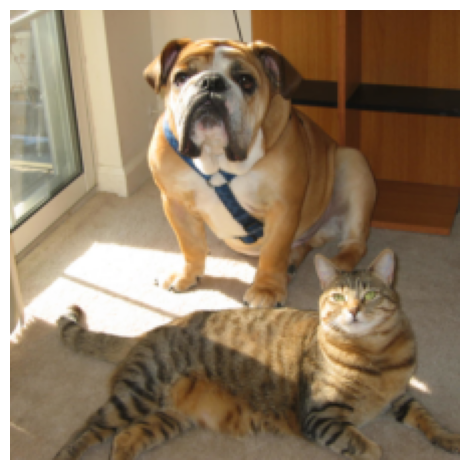

In [6]:
img = Image.open("dog_and_cat.jpg").convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)
img = inverse_transform(img_tensor.squeeze(0).cpu())
img = img.permute(1, 2, 0).numpy()


plt.imshow(img)
plt.axis("off")
plt.tight_layout()

with torch.no_grad():
    pred = resnet(img_tensor)
    _, top_idxs = torch.topk(pred, 10)
    top_idxs = top_idxs.squeeze(0).cpu().numpy()
    for idx in top_idxs:
        print(idx, imagenet_labels[idx])

### Compare Grad-CAM and raw activation maps

Generate saliency maps with Grad-CAM for top 2 classes, combine them together and compare with mean activations.

Activations shape:  torch.Size([1, 2048, 7, 7])


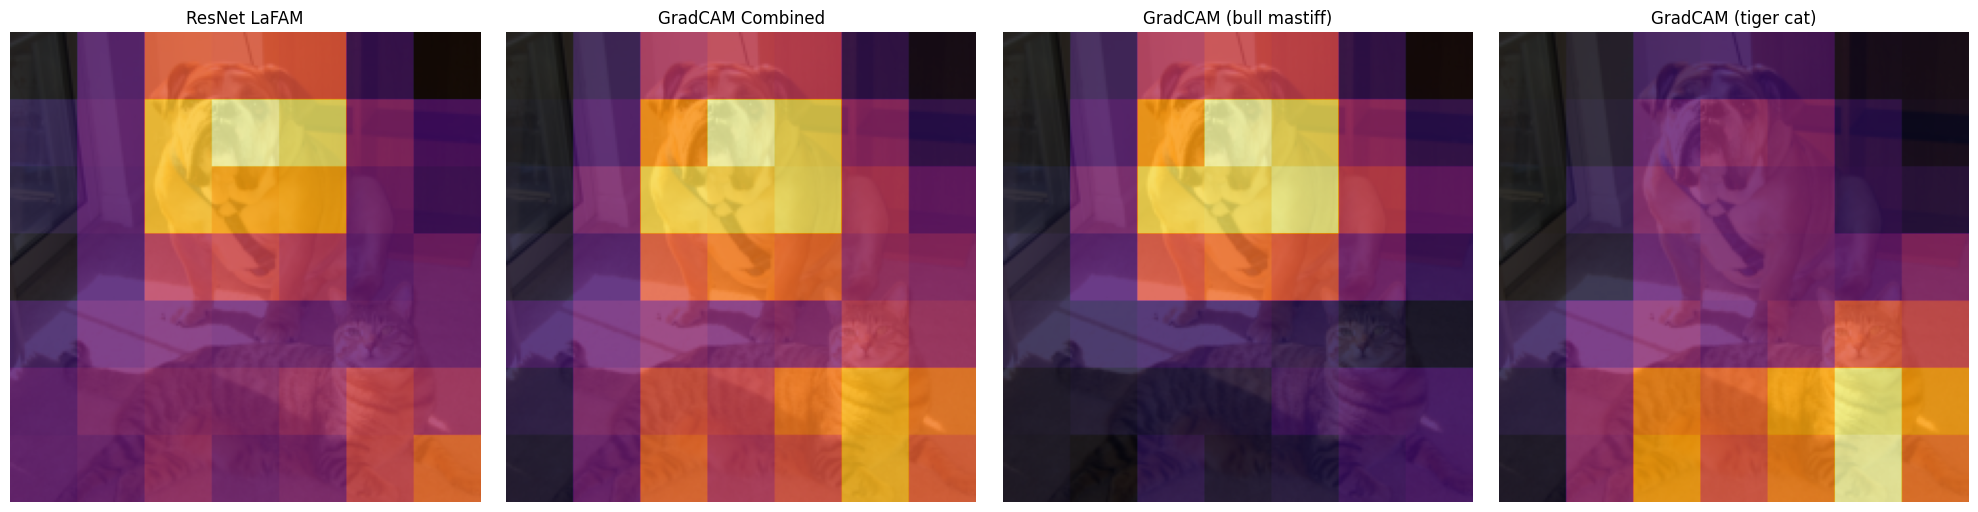

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# unsupervised saliency map extracted from the last CNN layer
with torch.no_grad():
    resnet_lafam_heatmap = resnet_layer4(img_tensor)
    print("Activations shape: ", resnet_lafam_heatmap.shape)

    resnet_lafam_heatmap = resnet_lafam_heatmap.mean(dim=1, keepdim=True)
    resnet_lafam_heatmap = normalize(resnet_lafam_heatmap)
    resnet_lafam_heatmap = (
        F.interpolate(resnet_lafam_heatmap, size=(224, 224), mode="nearest")
        .view(224, 224)
        .cpu()
    )

axs[0].imshow(img)
axs[0].imshow(resnet_lafam_heatmap, cmap="inferno", alpha=0.8)
axs[0].axis("off")
axs[0].set_title("ResNet LaFAM")


# Grad-CAM for top 2 predictions

layer_gc = LayerGradCam(resnet, resnet.layer4)

combined_gc = np.zeros((224, 224))

for i, cls in enumerate(top_idxs[:2]):
    x = img_tensor.clone().requires_grad_(True)
    attr = layer_gc.attribute(x, int(cls), relu_attributions=True).detach()
    attr = F.interpolate(attr, size=(224, 224), mode="nearest").cpu()
    attr = normalize(attr)
    attr = attr.view(224, 224).numpy()
    combined_gc += attr

    axs[i + 2].imshow(img)
    axs[i + 2].imshow(attr, cmap="inferno", alpha=0.8)
    axs[i + 2].axis("off")
    axs[i + 2].set_title(f"GradCAM ({imagenet_labels[cls]})")

combined_gc /= 2
axs[1].imshow(img)
axs[1].imshow(combined_gc, cmap="inferno", alpha=0.8)
axs[1].set_title("GradCAM Combined")
axs[1].axis("off")

plt.tight_layout()

### Compare ResNet Classifier and SSL Models

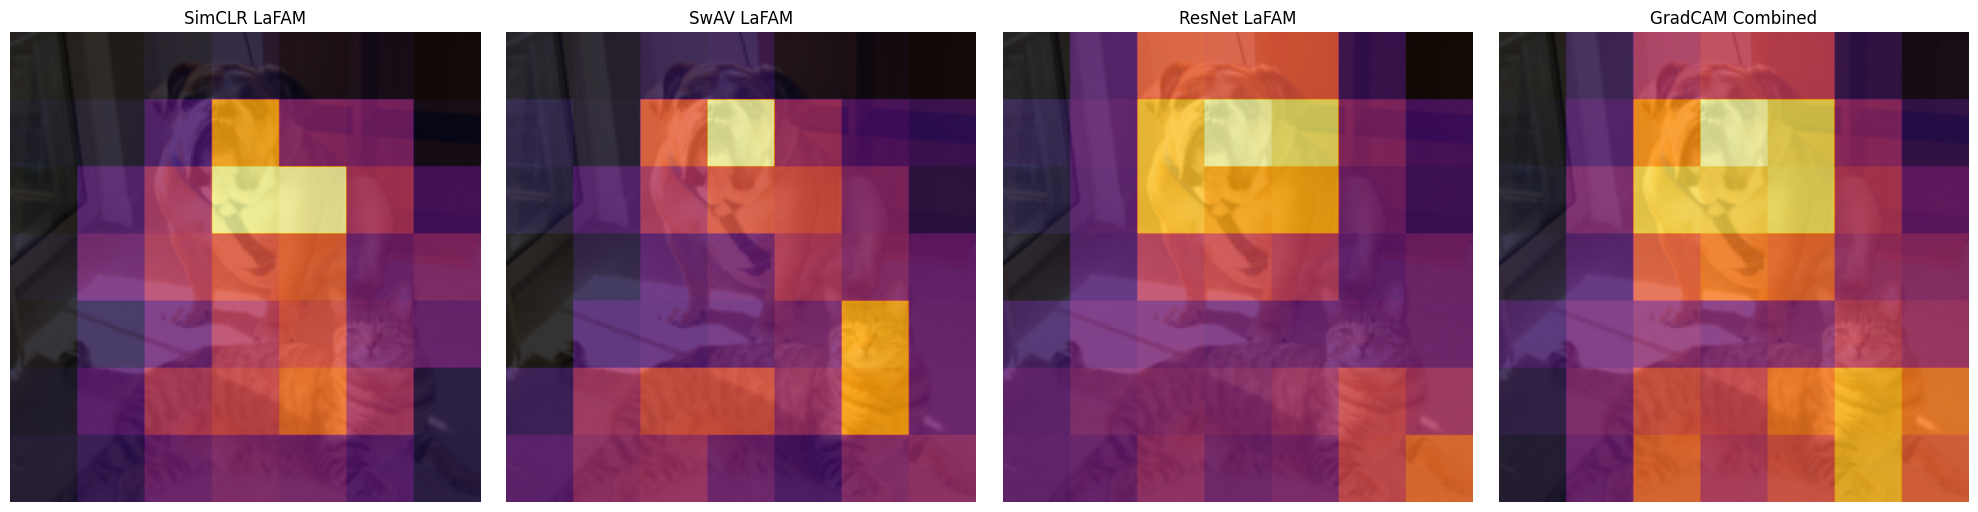

In [8]:
with torch.no_grad():
    simclr_heatmap = simclr_layer4(img_tensor)
    simclr_heatmap = simclr_heatmap.mean(dim=1, keepdim=True)
    simclr_heatmap = normalize(simclr_heatmap)
    simclr_heatmap = (
        F.interpolate(simclr_heatmap, size=(224, 224), mode="nearest")
        .view(224, 224)
        .cpu()
    )

with torch.no_grad():
    swav_heatmap = swav_layer4(img_tensor)
    swav_heatmap = swav_heatmap.mean(dim=1, keepdim=True)
    swav_heatmap = normalize(swav_heatmap)
    swav_heatmap = (
        F.interpolate(swav_heatmap, size=(224, 224), mode="nearest")
        .view(224, 224)
        .cpu()
    )

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img)
axs[0].imshow(simclr_heatmap, cmap="inferno", alpha=0.8)
axs[0].axis("off")
axs[0].set_title("SimCLR LaFAM")

axs[1].imshow(img)
axs[1].imshow(swav_heatmap, cmap="inferno", alpha=0.8)
axs[1].axis("off")
axs[1].set_title("SwAV LaFAM")

axs[2].imshow(img)
axs[2].imshow(resnet_lafam_heatmap, cmap="inferno", alpha=0.8)
axs[2].axis("off")
axs[2].set_title("ResNet LaFAM")

axs[3].imshow(img)
axs[3].imshow(combined_gc, cmap="inferno", alpha=0.8)
axs[3].axis("off")
axs[3].set_title("GradCAM Combined")

plt.tight_layout()

# PASCAL advanced demo

### Wrap attribution methods into classes

In [9]:
from RELAX import RELAX

class GradCAMHeatmap:
    def __init__(self, model, layer, imagenet_labels, interpolation, threshold=None):
        self.layer_gc = LayerGradCam(model, layer)
        self.imagenet_labels = imagenet_labels
        self.model = model
        self.interpolation = interpolation
        self.threshold = threshold

    def __call__(self, img_tensor):
        size = img_tensor.shape[-2:]
        with torch.no_grad():
            pred = self.model(img_tensor)
            pred = torch.argmax(pred, dim=1).item()
            pred_label = self.imagenet_labels[pred]
            pred_label = pred_label.split(",")[0]

        heatmap = self.layer_gc.attribute(
            img_tensor, int(pred), relu_attributions=True
        ).detach()
        heatmap = normalize(heatmap)
        if self.threshold is not None:
            heatmap[heatmap < self.threshold] = 0
        heatmap = F.interpolate(heatmap, size=size, mode=self.interpolation)
        return heatmap.squeeze(0), pred_label


class LaFAM:
    def __init__(self, model, interpolation, threshold=None):
        self.model = model
        self.interpolation = interpolation
        self.threshold = threshold

    @torch.no_grad()
    def __call__(self, img_tensor, silent=None):
        size = img_tensor.shape[-2:]
        heatmap = self.model(img_tensor)
        heatmap = heatmap.mean(dim=1, keepdim=True)
        heatmap = normalize(heatmap)
        if self.threshold is not None:
            heatmap[heatmap < self.threshold] = 0
        heatmap = F.interpolate(heatmap, size=size, mode=self.interpolation)
        return heatmap.squeeze(0)

## Load PASCAL dataset

In [10]:
pascal_labels = {
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "potted plant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tv/monitor",
}

pascal_ds = torchvision.datasets.VOCSegmentation(
    root="../data/VOCdevkit",
    year="2012",
    image_set="val",
    download=False,  # if already downloaded
    transform=transform,
    target_transform=SquareCropAndResize(224, interpolation=Image.NEAREST),
)

### Create pandas dataframe from torch dataset

Number of images: 1449


<AxesSubplot:title={'center':'Pascal VOC 2012 - labels distribution'}, xlabel='label_names'>

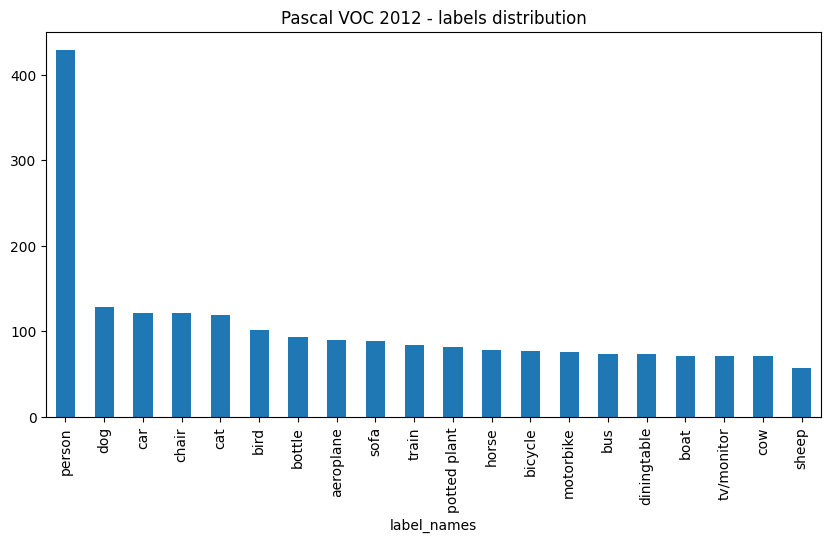

In [11]:
data = []

for idx, (_, mask) in enumerate(pascal_ds):
    mask = np.array(mask)
    labels = np.unique(mask)
    labels = labels[(labels != 0) & (labels != 255)]

    data.append(
        {
            "dataset_idx": idx,
            "labels": labels,
            "label_count": len(labels),
            "label_names": [pascal_labels[label] for label in labels],
        }
    )

pascal_df = pd.DataFrame(data)

print(f"Number of images: {len(pascal_df)}")

pascal_df["label_names"].explode().value_counts().plot(
    kind="bar", figsize=(10, 5), title="Pascal VOC 2012 - labels distribution"
)

Number of images: 885


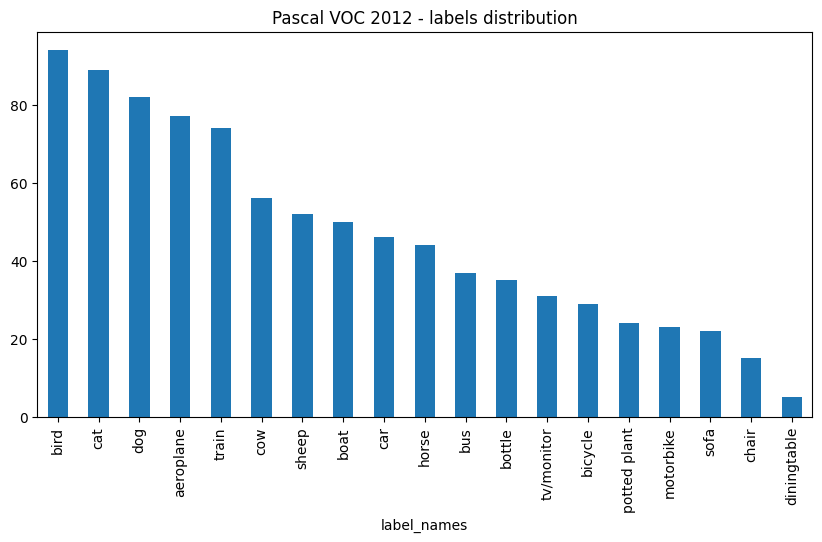

In [12]:
# exclude 'person' class
pascal_df = pascal_df[pascal_df['label_names'].apply(lambda x: 'person' not in x)].copy()
# filter out where label_count > 1
pascal_df = pascal_df[pascal_df['label_count'] == 1].copy()
print(f"Number of images: {len(pascal_df)}")

pascal_df['label_names'].explode().value_counts().plot(kind='bar', figsize=(10, 5), title="Pascal VOC 2012 - labels distribution");

Number of images: 664


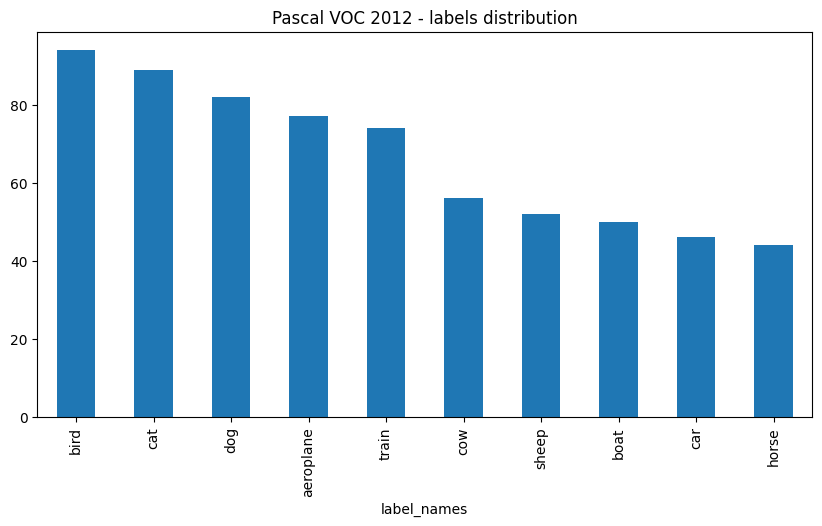

In [13]:
# filter out top 11 classes based on the count
top_10_classes = pascal_df['label_names'].explode().value_counts().index[:10]
pascal_df = pascal_df[pascal_df['label_names'].apply(lambda x: x[0] in top_10_classes)].copy()
print(f"Number of images: {len(pascal_df)}")

pascal_df['label_names'].explode().value_counts().plot(kind='bar', figsize=(10, 5), title="Pascal VOC 2012 - labels distribution");

## Visualize attribution maps

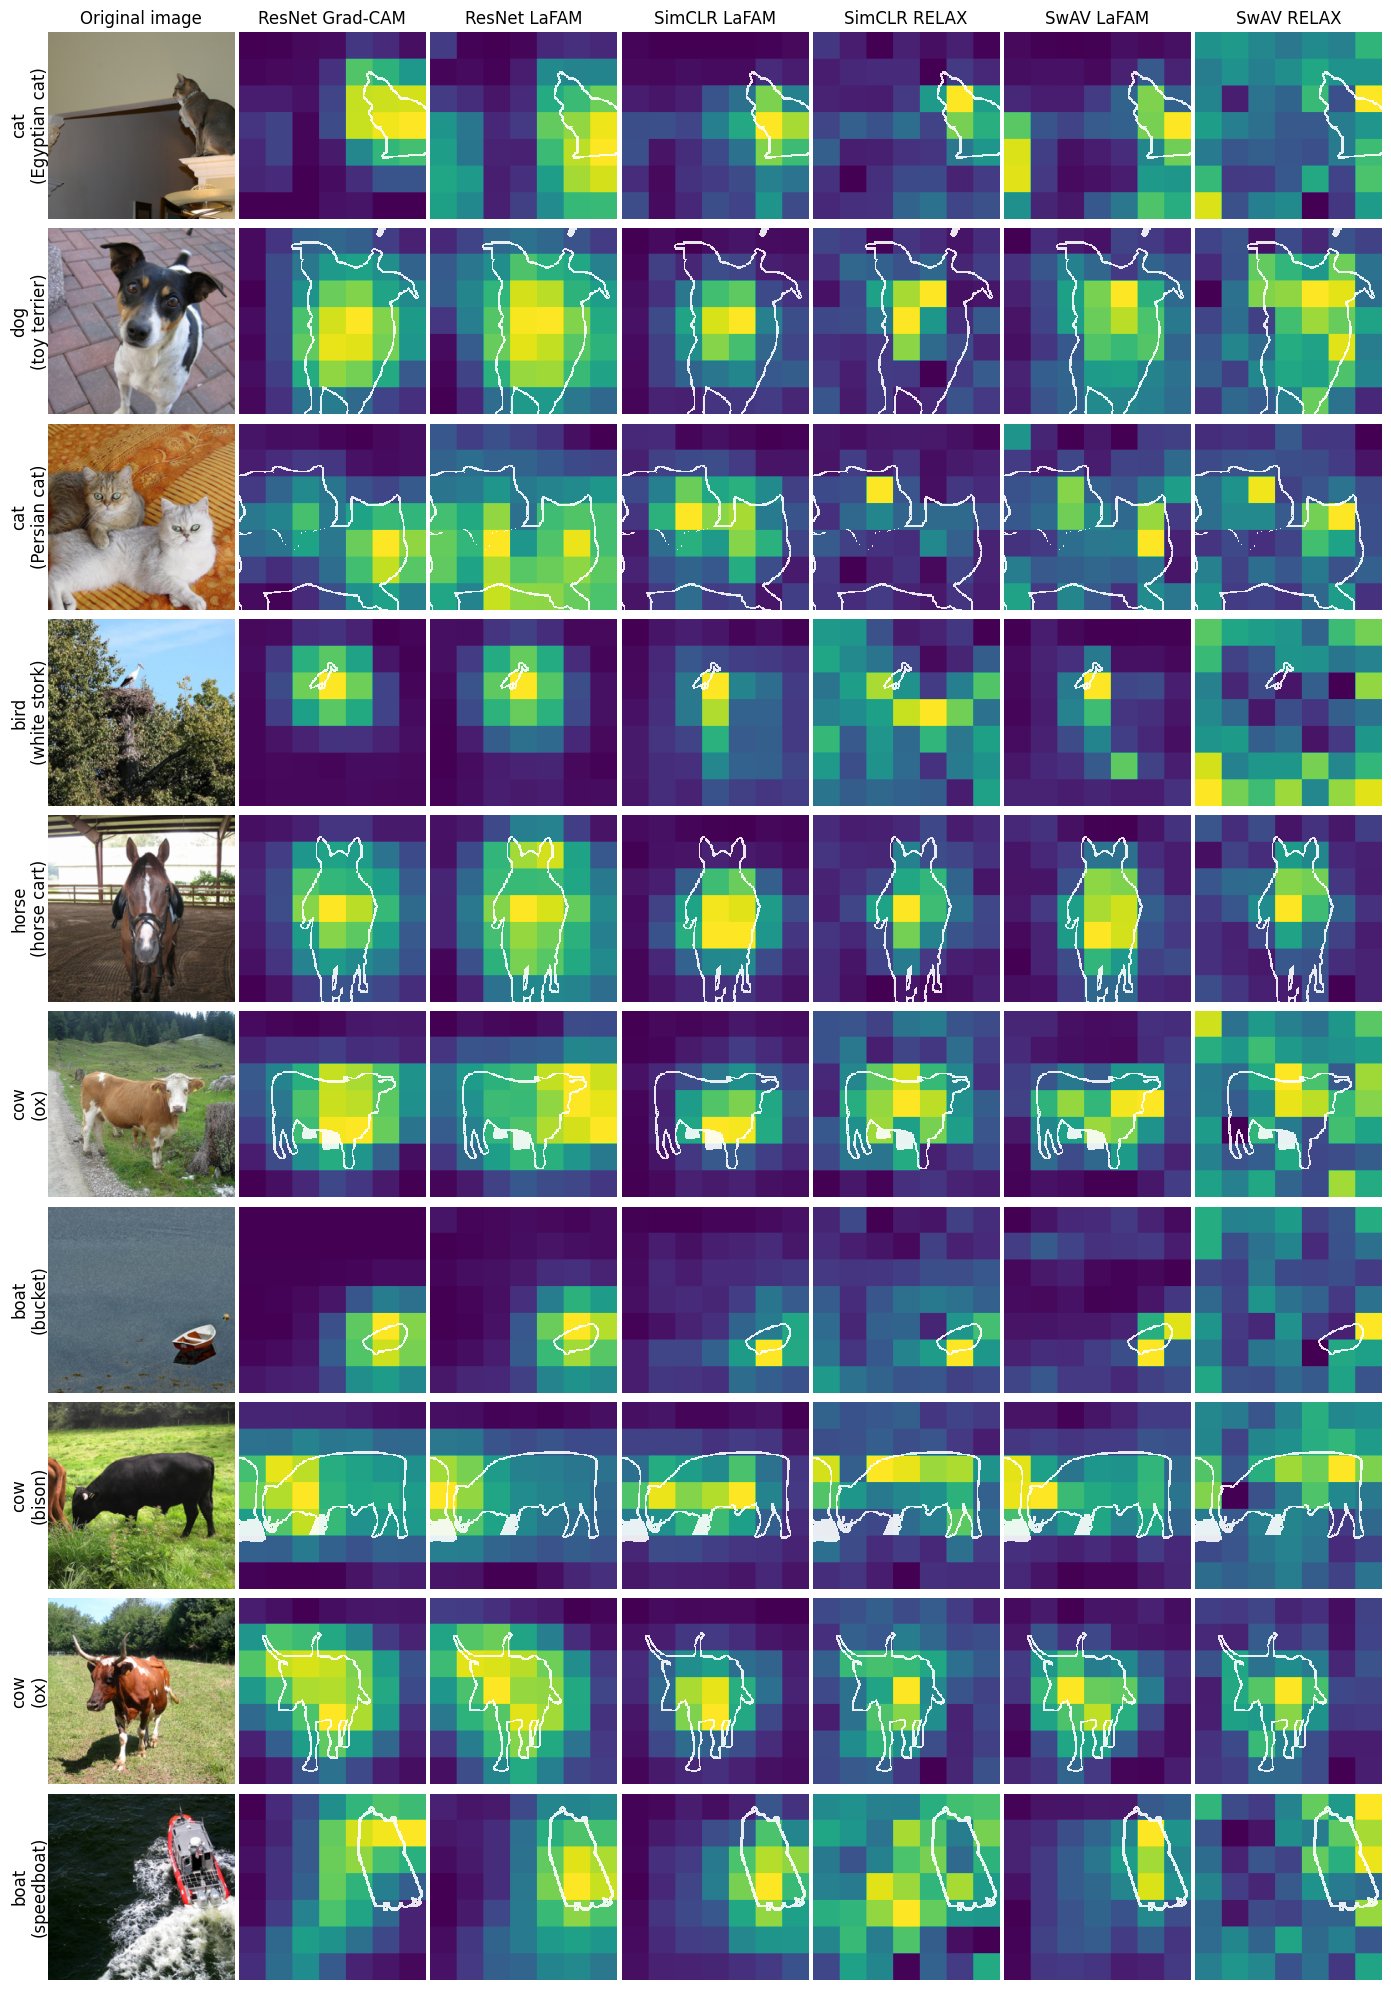

In [17]:
df_sample = pascal_df.sample(10)
df_sample.dataset_idx.values

threshold = None
interpolation = "nearest"

xai_methods = (
    ("ResNet LaFAM", LaFAM(resnet_layer4, interpolation)),
    ("SimCLR LaFAM", LaFAM(simclr_layer4, interpolation)),
    (
        "SimCLR RELAX",
        RELAX(
            simclr,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=threshold,
            unpack_output=lambda x: x[0],
            device=device,
            interpolation=interpolation,
        ),
    ),
    ("SwAV LaFAM", LaFAM(swav_layer4, interpolation)),
    (
        "SwAV RELAX",
        RELAX(
            swav,
            n_masks=2048,
            n_cells=7,
            occlusion_batch_size=1024,
            threshold=threshold,
            unpack_output=lambda x: x[0],
            device=device,
            interpolation=interpolation,
        ),
    ),
)

gradcam_heatmap = GradCAMHeatmap(resnet, resnet.layer4, imagenet_labels, interpolation)


fig, axes = plt.subplots(
    nrows=len(df_sample),
    ncols=len(xai_methods) + 2,
    figsize=((len(xai_methods) + 2) * 2, 2 * len(df_sample)),
)
for ax in axes.flatten():
    ax.axis("off")

for i, row in enumerate(df_sample.itertuples()):
    img_tensor, seg_img = pascal_ds[row.dataset_idx]
    img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()

    img_tensor = img_tensor.unsqueeze(0).to(device)

    seg = np.array(seg_img)
    # remove outline
    seg[seg == 255] = 0

    seg_classes = np.unique(seg)
    seg_classes = seg_classes[seg_classes != 0]
    seg_labels = [pascal_labels[i] for i in seg_classes]
    seg_labels = ", ".join(seg_labels)

    seg = np.array(seg_img)
    mask = np.zeros_like(seg).astype(np.float32)
    mask[seg == 255] = 1
    mask_alpha = plt.cm.gray(mask)
    mask_alpha[..., 3] = mask

    if i == 0:
        axes[i, 0].title.set_text("Original image")
        axes[i, 1].title.set_text("ResNet Grad-CAM")

    axes[i, 0].imshow(img, vmin=img.min(), vmax=img.max())

    # Grad-CAM
    heatmap, pred_label = gradcam_heatmap(img_tensor)

    axes[i, 1].imshow(heatmap[0].cpu().numpy(), cmap="viridis")
    axes[i, 1].imshow(mask_alpha, cmap="gray", interpolation="nearest", alpha=0.9)

    # add vertical title left
    axes[i, 0].text(
        -0.1,
        0.5,
        f"{seg_labels}\n({pred_label})",
        size=12,
        ha="center",
        va="center",
        rotation=90,
        transform=axes[i, 0].transAxes,
    )

    for j, method_info in enumerate(xai_methods):
        name, method = method_info
        heatmap = method(img_tensor, silent=True).cpu().numpy()
        if i == 0:
            axes[i, j + 2].title.set_text(name)
        axes[i, j + 2].imshow(heatmap[0], cmap="viridis")
        axes[i, j + 2].imshow(
            mask_alpha, cmap="gray", interpolation="nearest", alpha=0.9
        )

plt.tight_layout()
# remove margins
plt.subplots_adjust(wspace=0,hspace=.05)